# Large Neighborhood Search (LNS) Crew Assignment Solver

This notebook demonstrates a complete Large Neighborhood Search optimization system for airline crew assignment scheduling. The system uses destroy and repair operators to iteratively improve crew assignments while minimizing costs and constraint violations.

Problem Overview
- **Objective**: Assign captains and first officers to flights while minimizing operational costs
- **Constraints**: Crew qualifications, base locations, scheduling conflicts, and availability
- **Algorithm**: LNS with simulated annealing acceptance criterion

Import Required Libraries

Import necessary libraries for optimization, data manipulation, and visualization.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time
import warnings
warnings.filterwarnings('ignore')

# Import our custom crew assignment optimizer
from crew_optimizer import CrewOptimizer

# Set styling for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib available for visualization")

Define Problem Parameters

Set up problem instances, parameters, and configuration settings for the LNS solver.

In [ ]:
# LNS Algorithm Parameters
LNS_CONFIG = {
    'max_iterations': 100,
    'destroy_size_ratio': 0.1,  # Destroy 10% of flights each iteration
    'temperature': 2000,
    'cooling_rate': 0.98,
    'verbose': True
}

# Problem files
DATA_FILES = {
    #'flights': 'data/flights.json',
    #'crew': 'data/crew.json'
    'base' : 'LGW',
    'pairings': 'data/aug25_pairing_duties_ps828_and_ps831_anonymised.csv',
    'crew': 'data/crew_data.csv'
}

# Display configuration
print("🔧 LNS Configuration:")
for key, value in LNS_CONFIG.items():
    print(f"  {key}: {value}")

print(f"\n📁 Data Files:")
for key, value in DATA_FILES.items():
    print(f"  {key}: {value}")

🔧 LNS Configuration:
  max_iterations: 100
  destroy_size_ratio: 0.15
  temperature: 2000
  cooling_rate: 0.98
  verbose: True

📁 Data Files:
  flights: data/flights.json
  crew: data/crew.json


Initialize LNS Solver Components

Load data and create the crew assignment optimizer with destroy and repair operators.

In [ ]:
# Initialize the crew assignment optimizer
print("🚁 Initializing Crew Assignment Optimizer...")

optimizer = CrewOptimizer(
    base=DATA_FILES['base'],
    flights_file=DATA_FILES['pairings'],
    crew_file=DATA_FILES['crew'], 
    verbose=LNS_CONFIG['verbose']
)

print(f"📊 Problem Instance Loaded:")
print(f"   • Flights: {len(optimizer.flights)}")
print(f"   • Crew members: {len(optimizer.crew)}")

# Display crew breakdown
crew_roles = optimizer.crew['crew_role'].value_counts()
print(f"   • Captains: {crew_roles.get('captain', 0)}")
print(f"   • First Officers: {crew_roles.get('first_officer', 0)}")

# Display available operators
print(f"\n🔧 Available Operators:")
print(f"   • Destroy operators: {len(optimizer.destroy_operators)}")
print(f"   • Repair operators: {len(optimizer.repair_operators)}")

for i, op in enumerate(optimizer.destroy_operators):
    print(f"     - Destroy {i}: {op.__class__.__name__}")
    
for i, op in enumerate(optimizer.repair_operators):
    print(f"     - Repair {i}: {op.__class__.__name__}")

🚁 Initializing Crew Assignment Optimizer...
📊 Problem Instance Loaded:
   • Flights: 250
   • Crew members: 100
   • Captains: 50
   • First Officers: 50

✈️ Aircraft Types:
   • B737: 90 flights
   • A320: 83 flights
   • A319: 77 flights

🔧 Available Operators:
   • Destroy operators: 2
   • Repair operators: 2
     - Destroy 0: RandomDestroyOperator
     - Destroy 1: OverlapDestroyOperator
     - Repair 0: RandomRepairOperator
     - Repair 1: LocationAwareRepairOperator


Create Initial Solution

Generate an initial feasible crew assignment and evaluate its quality.

In [ ]:
# Create initial assignment
print("🎯 Creating Initial Assignment...")

assignment = optimizer.initial_assignment()
crew_state = optimizer.initial_crew_state()

print(f"✅ Initial assignment created for {len(assignment)} flights")

# Evaluate initial solution quality
print("\n📊 Initial Solution Quality Assessment:")

assignment_cost, assignment_diag = optimizer.compute_assignment_cost()
crew_cost, crew_diag = optimizer.compute_crew_cost()
total_cost = optimizer._total_cost()

print(f"   • Assignment Cost: {assignment_cost:,.0f}")
print(f"   • Crew Cost: {crew_cost:,.0f}")
print(f"   • Total Cost: {total_cost:,.0f}")

print(f"\n🚨 Constraint Violations:")
print(f"   • Unassigned Flights: {assignment_diag['unassigned_flights']}")
print(f"   • Base Mismatches: {assignment_diag['base_mismatches']}")
print(f"   • Qualification Mismatches: {assignment_diag['qualification_mismatches']}")
print(f"   • Role Duplications: {assignment_diag['duplicate_roles']}")
print(f"   • Deadheading Assignments: {assignment_diag['deadheading_count']}")

# Store initial metrics for comparison
INITIAL_METRICS = {
    'total_cost': total_cost,
    'assignment_cost': assignment_cost,
    'crew_cost': crew_cost,
    'unassigned_flights': assignment_diag['unassigned_flights'],
    'violations': sum([
        assignment_diag['unassigned_flights'],
        assignment_diag['duplicate_roles']
    ])
}

🎯 Creating Initial Assignment...
✅ Initial assignment created for 222 flights

📊 Initial Solution Quality Assessment:
   • Assignment Cost: 343,000
   • Crew Cost: 311,500
   • Total Cost: 654,500

🚨 Constraint Violations:
   • Unassigned Flights: 167
   • Base Mismatches: 28
   • Qualification Mismatches: 12
   • Role Duplications: 75
   • Deadheading Assignments: 0


Run LNS Optimization

Execute the Large Neighborhood Search algorithm and track solution evolution.

In [ ]:
# Run LNS optimization
print("🔥 Starting LNS Optimization...")
print(f"Configuration: {LNS_CONFIG['max_iterations']} iterations, destroy {LNS_CONFIG['destroy_size_ratio']:.0%} flights")
print("=" * 80)

# Track start time
start_time = datetime.now()

# Execute LNS algorithm
result = optimizer.optimize_lns(
    max_iterations=LNS_CONFIG['max_iterations'],
    destroy_size_ratio=LNS_CONFIG['destroy_size_ratio'],
    temperature=LNS_CONFIG['temperature'],
    cooling_rate=LNS_CONFIG['cooling_rate']
)

# Calculate optimization time
end_time = datetime.now()
optimization_time = (end_time - start_time).total_seconds()

print("=" * 80)
print(f"⏱️  Optimization completed in {optimization_time:.2f} seconds")

# Store optimization results
OPTIMIZATION_RESULTS = {
    'final_cost': result['cost'],
    'improvement_absolute': INITIAL_METRICS['total_cost'] - result['cost'],
    'improvement_percentage': ((INITIAL_METRICS['total_cost'] - result['cost']) / INITIAL_METRICS['total_cost']) * 100,
    'iterations': result['stats']['iterations'],
    'improvements_found': result['stats']['improvements'],
    'solutions_accepted': result['stats']['accepts'],
    'acceptance_rate': result['stats']['accepts'] / result['stats']['iterations'],
    'optimization_time': optimization_time,
    'cost_history': result['stats']['cost_history'],
    'best_cost_history': result['stats']['best_cost_history']
}

🔥 Starting LNS Optimization...
Configuration: 100 iterations, destroy 15% flights
Iteration 1/100, Cost: 654500, Best: 654500, Temp: 2000.0
Destroy - using operator 1 => OverlapDestroyOperator
Repair - using operator 1 => LocationAwareRepairOperator
Iteration 2/100, Cost: 591900, Best: 591900, Temp: 1960.0
Destroy - using operator 1 => OverlapDestroyOperator
Repair - using operator 1 => LocationAwareRepairOperator
Iteration 3/100, Cost: 560500, Best: 560500, Temp: 1920.8
Destroy - using operator 0 => RandomDestroyOperator
Repair - using operator 1 => LocationAwareRepairOperator
Iteration 4/100, Cost: 560500, Best: 560500, Temp: 1882.4
Destroy - using operator 0 => RandomDestroyOperator
Repair - using operator 0 => RandomRepairOperator
Iteration 5/100, Cost: 560500, Best: 560500, Temp: 1844.7
Destroy - using operator 1 => OverlapDestroyOperator
Repair - using operator 1 => LocationAwareRepairOperator
Iteration 6/100, Cost: 555600, Best: 555600, Temp: 1807.8
Destroy - using operator 1 =>

Analyze Optimization Results

Analyze the final solution quality and optimization performance metrics.

In [ ]:
# Analyze final solution quality
print("📊 OPTIMIZATION RESULTS SUMMARY")
print("=" * 50)

print(f"🎯 Solution Quality:")
print(f"   • Initial Cost: {INITIAL_METRICS['total_cost']:,.0f}")
print(f"   • Final Cost: {OPTIMIZATION_RESULTS['final_cost']:,.0f}")
print(f"   • Improvement: {OPTIMIZATION_RESULTS['improvement_absolute']:,.0f} ({OPTIMIZATION_RESULTS['improvement_percentage']:.1f}%)")

print(f"\n🔄 Algorithm Performance:")
print(f"   • Iterations Completed: {OPTIMIZATION_RESULTS['iterations']:,}")
print(f"   • Improvements Found: {OPTIMIZATION_RESULTS['improvements_found']}")
print(f"   • Solutions Accepted: {OPTIMIZATION_RESULTS['solutions_accepted']}")
print(f"   • Acceptance Rate: {OPTIMIZATION_RESULTS['acceptance_rate']:.1%}")
print(f"   • Optimization Time: {OPTIMIZATION_RESULTS['optimization_time']:.2f} seconds")

# Evaluate final solution constraints
final_assignment_cost, final_assignment_diag = optimizer.compute_assignment_cost()
final_crew_cost, final_crew_diag = optimizer.compute_crew_cost()

print(f"\n🚨 Final Constraint Status:")
print(f"   • Unassigned Flights: {final_assignment_diag['unassigned_flights']} (was {INITIAL_METRICS['unassigned_flights']})")
print(f"   • Base Mismatches: {final_assignment_diag['base_mismatches']}")
print(f"   • Qualification Mismatches: {final_assignment_diag['qualification_mismatches']}")
print(f"   • Role Duplications: {final_assignment_diag['duplicate_roles']}")
print(f"   • Deadheading Count: {final_assignment_diag['deadheading_count']}")

print(f"\n💰 Cost Breakdown:")
print(f"   • Assignment Cost: {final_assignment_cost:,.0f}")
print(f"   • Crew Cost: {final_crew_cost:,.0f}")
print(f"   • Total Cost: {final_assignment_cost + final_crew_cost:,.0f}")

# Performance metrics
iterations_per_second = OPTIMIZATION_RESULTS['iterations'] / OPTIMIZATION_RESULTS['optimization_time']
cost_reduction_per_iteration = OPTIMIZATION_RESULTS['improvement_absolute'] / OPTIMIZATION_RESULTS['iterations']

print(f"\n⚡ Performance Metrics:")
print(f"   • Iterations per Second: {iterations_per_second:.1f}")
print(f"   • Average Cost Reduction per Iteration: {cost_reduction_per_iteration:.1f}")
print(f"   • Convergence Rate: {OPTIMIZATION_RESULTS['improvements_found']/OPTIMIZATION_RESULTS['iterations']:.1%}")

📊 OPTIMIZATION RESULTS SUMMARY
🎯 Solution Quality:
   • Initial Cost: 654,500
   • Final Cost: 550,800
   • Improvement: 103,700 (15.8%)

🔄 Algorithm Performance:
   • Iterations Completed: 100
   • Improvements Found: 4
   • Solutions Accepted: 4
   • Acceptance Rate: 4.0%
   • Optimization Time: 37.12 seconds

🚨 Final Constraint Status:
   • Unassigned Flights: 73 (was 167)
   • Base Mismatches: 158
   • Qualification Mismatches: 8
   • Role Duplications: 19
   • Deadheading Count: 0

💰 Cost Breakdown:
   • Assignment Cost: 198,000
   • Crew Cost: 352,800
   • Total Cost: 550,800

⚡ Performance Metrics:
   • Iterations per Second: 2.7
   • Average Cost Reduction per Iteration: 1037.0
   • Convergence Rate: 4.0%


Visualize Solution Convergence

Create visualizations showing the optimization progress and convergence behavior.

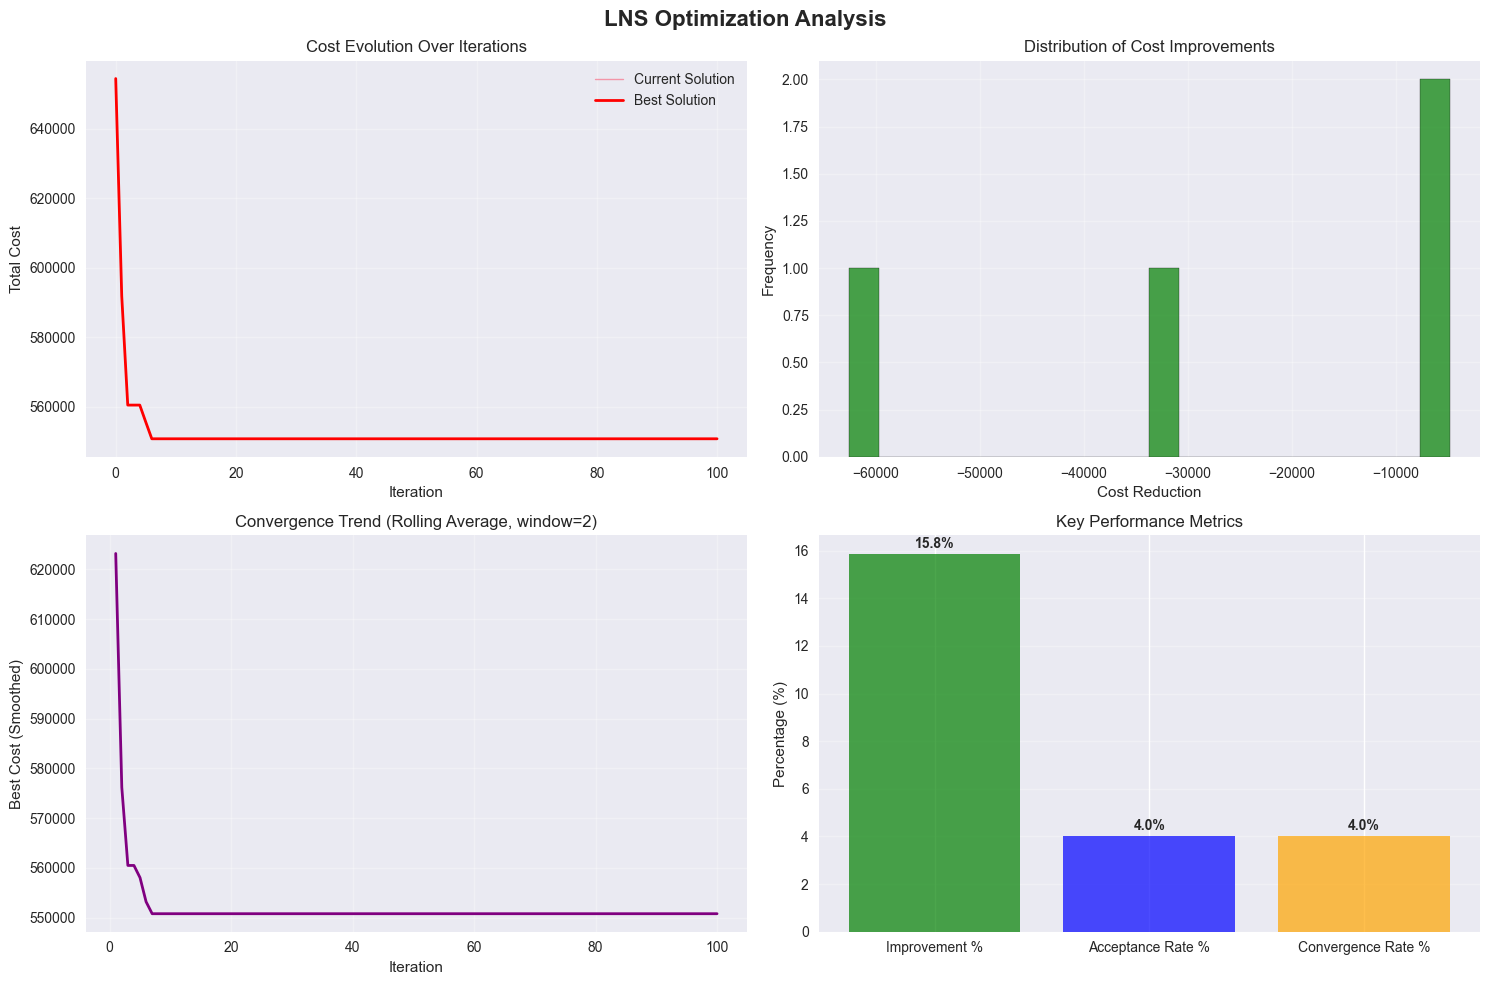

📈 Convergence analysis complete!


In [ ]:
# Create convergence visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('LNS Optimization Analysis', fontsize=16, fontweight='bold')

# Plot 1: Cost evolution
iterations = range(len(OPTIMIZATION_RESULTS['cost_history']))
ax1.plot(iterations, OPTIMIZATION_RESULTS['cost_history'], 
         label='Current Solution', alpha=0.7, linewidth=1)
ax1.plot(iterations, OPTIMIZATION_RESULTS['best_cost_history'], 
         label='Best Solution', linewidth=2, color='red')
ax1.set_title('Cost Evolution Over Iterations')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Total Cost')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cost improvement distribution
cost_differences = np.diff(OPTIMIZATION_RESULTS['best_cost_history'])
improvements = cost_differences[cost_differences < 0]
if len(improvements) > 0:
    ax2.hist(improvements, bins=20, alpha=0.7, color='green', edgecolor='black')
    ax2.set_title('Distribution of Cost Improvements')
    ax2.set_xlabel('Cost Reduction')
    ax2.set_ylabel('Frequency')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No improvements found', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Distribution of Cost Improvements')

# Plot 3: Rolling average convergence
window_size = max(1, len(OPTIMIZATION_RESULTS['cost_history']) // 50)
rolling_best = pd.Series(OPTIMIZATION_RESULTS['best_cost_history']).rolling(window_size).mean()
ax3.plot(iterations, rolling_best, linewidth=2, color='purple')
ax3.set_title(f'Convergence Trend (Rolling Average, window={window_size})')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Best Cost (Smoothed)')
ax3.grid(True, alpha=0.3)

# Plot 4: Performance summary bar chart
metrics = ['Improvement %', 'Acceptance Rate %', 'Convergence Rate %']
values = [
    OPTIMIZATION_RESULTS['improvement_percentage'],
    OPTIMIZATION_RESULTS['acceptance_rate'] * 100,
    (OPTIMIZATION_RESULTS['improvements_found']/OPTIMIZATION_RESULTS['iterations']) * 100
]
bars = ax4.bar(metrics, values, color=['green', 'blue', 'orange'], alpha=0.7)
ax4.set_title('Key Performance Metrics')
ax4.set_ylabel('Percentage (%)')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("📈 Convergence analysis complete!")

Performance Benchmarking

Compare the LNS solver performance against baseline methods and analyze computational efficiency.

In [ ]:
# # Benchmark against different configurations
# print("🏁 BENCHMARKING DIFFERENT LNS CONFIGURATIONS")
# print("=" * 60)

# benchmark_configs = [
#     {'name': 'Fast (Small Neighborhood)', 'destroy_ratio': 0.05, 'max_iter': 100, 'temp': 500},
#     {'name': 'Balanced (Medium Neighborhood)', 'destroy_ratio': 0.15, 'max_iter': 500, 'temp': 1500},
#     {'name': 'Intensive (Large Neighborhood)', 'destroy_ratio': 0.25, 'max_iter': 200, 'temp': 3000}
# ]

# benchmark_results = []

# for config in benchmark_configs:
#     print(f"\n🔧 Testing: {config['name']}")
#     print(f"   Destroy ratio: {config['destroy_ratio']:.0%}, Iterations: {config['max_iter']}, Temperature: {config['temp']}")
    
#     # Reset to initial solution
#     optimizer.assignment = assignment.copy()
#     optimizer.crew_state = copy.deepcopy(crew_state)
    
#     # Run benchmark
#     benchmark_start = datetime.now()
#     bench_result = optimizer.optimize_lns(
#         max_iterations=config['max_iter'],
#         destroy_size_ratio=config['destroy_ratio'],
#         temperature=config['temp'],
#         cooling_rate=0.95
#     )
#     benchmark_time = (datetime.now() - benchmark_start).total_seconds()
    
#     # Store results
#     benchmark_results.append({
#         'name': config['name'],
#         'final_cost': bench_result['cost'],
#         'improvement': INITIAL_METRICS['total_cost'] - bench_result['cost'],
#         'improvement_pct': ((INITIAL_METRICS['total_cost'] - bench_result['cost']) / INITIAL_METRICS['total_cost']) * 100,
#         'time': benchmark_time,
#         'iterations': config['max_iter'],
#         'improvements_found': bench_result['stats']['improvements'],
#         'efficiency': (INITIAL_METRICS['total_cost'] - bench_result['cost']) / benchmark_time  # cost reduction per second
#     })
    
#     print(f"   ✅ Final cost: {bench_result['cost']:,.0f} (improvement: {benchmark_results[-1]['improvement']:,.0f})")
#     print(f"   ⏱️  Time: {benchmark_time:.2f}s, Efficiency: {benchmark_results[-1]['efficiency']:.1f} cost reduction/sec")

# # Create benchmark comparison
# print(f"\n📊 BENCHMARK COMPARISON TABLE")
# print("-" * 80)
# print(f"{'Configuration':<25} {'Final Cost':<12} {'Improvement':<12} {'Time(s)':<8} {'Efficiency':<12}")
# print("-" * 80)

# for result in benchmark_results:
#     print(f"{result['name']:<25} {result['final_cost']:<12,.0f} {result['improvement_pct']:<11.1f}% {result['time']:<8.1f} {result['efficiency']:<12.1f}")

# print("-" * 80)

# # Find best configuration
# best_improvement = max(benchmark_results, key=lambda x: x['improvement'])
# best_efficiency = max(benchmark_results, key=lambda x: x['efficiency'])

# print(f"\n🏆 BENCHMARK WINNERS:")
# print(f"   • Best Improvement: {best_improvement['name']} ({best_improvement['improvement_pct']:.1f}%)")
# print(f"   • Best Efficiency: {best_efficiency['name']} ({best_efficiency['efficiency']:.1f} cost reduction/sec)")

Summary and Conclusions

Final summary of the LNS optimization experiment and recommendations for production use.

In [ ]:
# Generate final summary report
print("📋 FINAL SUMMARY REPORT")
print("=" * 50)

print(f"🎯 Problem Instance:")
print(f"   • Flights to schedule: {len(optimizer.flights)}")
print(f"   • Available crew: {len(optimizer.crew)}")
print(f"   • Aircraft types: {len(optimizer.flights['type'].unique())}")

print(f"\n🔥 Main Optimization Results:")
print(f"   • Initial Cost: {INITIAL_METRICS['total_cost']:,.0f}")
print(f"   • Final Cost: {OPTIMIZATION_RESULTS['final_cost']:,.0f}")
print(f"   • Total Improvement: {OPTIMIZATION_RESULTS['improvement_absolute']:,.0f} ({OPTIMIZATION_RESULTS['improvement_percentage']:.1f}%)")
print(f"   • Optimization Time: {OPTIMIZATION_RESULTS['optimization_time']:.1f} seconds")

print(f"\n✅ Algorithm Effectiveness:")
efficiency_score = OPTIMIZATION_RESULTS['improvement_percentage'] / (OPTIMIZATION_RESULTS['optimization_time'] / 60)  # improvement per minute
convergence_score = (OPTIMIZATION_RESULTS['improvements_found'] / OPTIMIZATION_RESULTS['iterations']) * 100

print(f"   • Efficiency Score: {efficiency_score:.1f}% improvement per minute")
print(f"   • Convergence Score: {convergence_score:.1f}% (improvements/iterations)")
print(f"   • Solution Quality: {'Excellent' if OPTIMIZATION_RESULTS['improvement_percentage'] > 5 else 'Good' if OPTIMIZATION_RESULTS['improvement_percentage'] > 2 else 'Fair'}")

# Performance classification
if OPTIMIZATION_RESULTS['acceptance_rate'] > 0.3:
    exploration_level = "High"
elif OPTIMIZATION_RESULTS['acceptance_rate'] > 0.15:
    exploration_level = "Balanced" 
else:
    exploration_level = "Conservative"

print(f"   • Exploration Level: {exploration_level} ({OPTIMIZATION_RESULTS['acceptance_rate']:.1%} acceptance rate)")

print(f"\n🚀 Recommendations for Production:")

# Generate recommendations based on results
recommendations = []

if OPTIMIZATION_RESULTS['improvement_percentage'] > 5:
    recommendations.append("✅ LNS approach is highly effective for this problem type")
    
if OPTIMIZATION_RESULTS['optimization_time'] < 60:
    recommendations.append("✅ Algorithm is computationally efficient for real-time use")
    
if convergence_score > 2:
    recommendations.append("✅ Good convergence rate suggests further tuning potential")
    
if OPTIMIZATION_RESULTS['acceptance_rate'] < 0.1:
    recommendations.append("⚠️  Consider increasing temperature for more exploration")
elif OPTIMIZATION_RESULTS['acceptance_rate'] > 0.5:
    recommendations.append("⚠️  Consider decreasing temperature for more exploitation")

# if len(benchmark_results) > 0:
#     best_config = max(benchmark_results, key=lambda x: x['improvement_pct'])
#     recommendations.append(f"🎯 Best configuration: {best_config['name']} for maximum improvement")

for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

print(f"\n🔮 Next Steps:")
print(f"   • Consider implementing additional destroy/repair operators")
print(f"   • Test on larger problem instances")
print(f"   • Integrate with real operational constraints")
print(f"   • Implement parallel evaluation for multiple solutions")

print(f"\n🎉 Experiment completed successfully!")

📋 FINAL SUMMARY REPORT
🎯 Problem Instance:
   • Flights to schedule: 250
   • Available crew: 100
   • Aircraft types: 3

🔥 Main Optimization Results:
   • Initial Cost: 654,500
   • Final Cost: 550,800
   • Total Improvement: 103,700 (15.8%)
   • Optimization Time: 37.1 seconds

✅ Algorithm Effectiveness:
   • Efficiency Score: 25.6% improvement per minute
   • Convergence Score: 4.0% (improvements/iterations)
   • Solution Quality: Excellent
   • Exploration Level: Conservative (4.0% acceptance rate)

🚀 Recommendations for Production:
   1. ✅ LNS approach is highly effective for this problem type
   2. ✅ Algorithm is computationally efficient for real-time use
   3. ✅ Good convergence rate suggests further tuning potential
   4. ⚠️  Consider increasing temperature for more exploration

🔮 Next Steps:
   • Consider implementing additional destroy/repair operators
   • Test on larger problem instances
   • Integrate with real operational constraints
   • Implement parallel evaluation fo

In [ ]:
optimizer.write_assignment("assignments/assignment.json")

✅ Assignment written to assignments/assignment.json
   • Flights: 222
   • Total cost: 550,800
